# Python - A Crash Course By Example

## Tensorflow

Dr. Victor Pankratius<br>
Massachusetts Institute of Technology<br>
http://www.victorpankratius.com

### Background

TensorFlow:
Large-Scale Machine Learning on Heterogeneous Distributed Systems, Abadi et al, 2015, Google Research
http://download.tensorflow.org/paper/whitepaper2015.pdf


In principle, your program is expressed as a Dataflow graph. Dataflow programming languages have a rich history, see https://en.wikipedia.org/wiki/Dataflow_programming 

In Tensorflow, you can specify dataflow graphs using:
- Element-wise mathematical operations Add, Sub, Mul, Div, Exp, Log, Greater, Less, Equal, ...
- Array operations Concat, Slice, Split, Constant, Rank, Shape, Shuffle, ...
- Matrix operations MatMul, MatrixInverse, MatrixDeterminant, ...
- Stateful operations Variable, Assign, AssignAdd, ...
- Neural-net building blocks SoftMax, Sigmoid, ReLU, Convolution2D, MaxPool, ...
- Checkpointing operations Save, Restore
- Queue and synchronization operations Enqueue, Dequeue, MutexAcquire, MutexRelease, ...
- Control flow operations Merge, Switch, Enter, Leave, NextIteration


There are other higher-level APIs that are built on top of Tensorflow to provide more practical abstractions, e.g., 

- Keras https://keras.io/ for deep learning


How to "program" in Tensorflow?:
- Phase 1: Construct a data flow graph, using Tensorflow operations
- Phase 2: Use a "session" to execute the graph and its operations

#### Data Types

TF has data types, e.g., 

---
##### Constants

```python
tf.constant(
    value,
    dtype=None,
    shape=None,
    name='Const',
    verify_shape=False
)
```
   
```python
#Constant 1-D Tensor populated with value list.
tensor = tf.constant([1, 2, 3, 4, 5, 6, 7]) => [1 2 3 4 5 6 7]
```


```python
# Constant 2-D tensor populated with scalar value -1.
tensor = tf.constant(-1.0, shape=[2, 3]) => [[-1. -1. -1.]
                                             [-1. -1. -1.]]
```

```python
# Another example
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
```
https://www.tensorflow.org/api_docs/python/tf/constant

---
##### Variables
```python
w = tf.Variable(<initial-value>, name=<optional-name>)
```
    
maintain state in dataflow graph across calls to run(). Add variable to graph by creating an instance of the class Variable.

```python
my_variable = tf.get_variable("my_variable", [1, 2, 3])
my_int_variable = tf.get_variable("my_int_variable", [1, 2, 3], dtype=tf.int32,
  initializer=tf.zeros_initializer)
```

https://www.tensorflow.org/api_docs/python/tf/Variable

---
##### Tensor

tf.Tensor is a class. In TensorFlow, a Tensor is a symbolic handle to one of the outputs of an Operation. It does not hold the values of that operation's output, but instead provides a means of computing those values in a TensorFlow tf.Session.

https://www.tensorflow.org/api_docs/python/tf/Tensor


---
##### Placeholder

Sometimes, we don't know the actual values needed in the dataflow graph because they are provided later (e.g., think of a neural network fed with data later). Therefore, we need to assemble the graph without knowing the actual values needed for computation. This is why placeholders are needed: 

```python
tf.placeholder(
    dtype,
    shape=None,
    name=None
)
```

Inserts a placeholder for a tensor.
```python
# create a placeholder of type float 32-bit, shape is a vector of 3 elements
a = tf.placeholder(tf.float32, shape=[3])
```
https://www.tensorflow.org/api_docs/python/tf/placeholder

---
##### Dataflow Graph

A tf.Graph contains two relevant kinds of information:
- Graph structure: The nodes and edges of the graph
- Graph collections: metadata. For example, when you create a tf.Variable, it is added by default to collections representing "global variables" and "trainable variables".

The easiest way to create a visualization for TensorBoard is to pass a tf.Graph when creating the tf.summary.FileWriter.

https://www.tensorflow.org/guide/graphs <br>
https://www.tensorflow.org/guide/graph_viz

In [4]:
import tensorflow as tf

## Demo: Manually create a simple dataflow graph & visualize it in TensorBoard

In [ ]:
#clear defined variables etc.
tf.reset_default_graph()   

# create a dataflow graph
a = tf.constant(3, name="a",dtype=tf.float32)
b = tf.constant(5, name="b",dtype=tf.float32)
c = tf.add(a, b, name="add")

# create a another subgraph
d = tf.constant([[1.0, 2.0], [3.0, 4.0]],name="tensor1")
e = tf.constant([[1.0, 1.0], [0.0, 1.0]],name="tensor2")
f = tf.matmul(d, e)

#connect the two pieces
g = tf.add(c,tf.reduce_mean(f))

with tf.Session() as s:
    # or creating the writer inside the session
    writer = tf.summary.FileWriter('./graphs', s.graph)
    print(s.run(c))
    print(s.run(f))
    print(s.run(g))
    
# close the writer when you’re done using it
writer.close()

#in comamnd line, run "tensorboard --logdir=“/graphs” --port=6006", open http://localhost:6006 in Web browser

## Demo: Simple linear regression from an XLS file

Based on http://web.stanford.edu/class/cs20si/lectures/notes_03.pdf

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import xlrd
#clear defined variables etc.
tf.reset_default_graph()   

In [160]:
DATA_FILE = "data.xls"

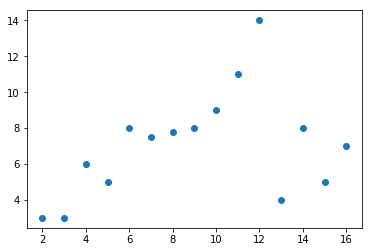

In [161]:
# Step 1: read in data from the .xls file

book = xlrd.open_workbook(DATA_FILE, encoding_override="utf-8")
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

plt.scatter(data[:,0], data[:,1])

In [162]:
# Step 2: create placeholders for input X and label Y

X = tf.placeholder(tf.float32, name="X")
Y = tf.placeholder(tf.float32, name="Y")

In [163]:
# Step 3: create weight and bias, initialized to 0

w = tf.Variable(0.0, name="weights")
b = tf.Variable(0.0, name="bias")

In [176]:
# Step 4: construct model to predict Y from X

Y_predicted = X * w + b

In [177]:
# Step 5: use the square error as the loss function

loss = tf.square(Y - Y_predicted, name="loss")

In [178]:
# Step 6: using gradient descent with learning rate of 0.01 to minimize loss

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

In [179]:
with tf.Session() as sess:
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer())
    
    # Step 8: train the model
    for i in range(10): # run 10 epochs
        for x, y in data:
            # Session runs train_op to minimize loss
            sess.run([optimizer], feed_dict={X: x, Y:y})
 
    # Step 9: output the values of w and b
    w_value, b_value = sess.run([w, b])

In [180]:
print(w_value,b_value)

0.44914556 0.34561116


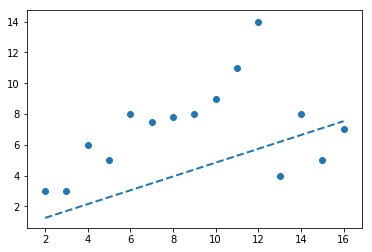

In [181]:
# Plot model prediction and actual data
x = np.linspace(np.min(data[:,0]), np.max(data[:,0]), 500)
fig, ax = plt.subplots()
ax.plot(x, x*w_value+b_value, '--', linewidth=2,label='model')
ax.scatter(data[:,0], data[:,1])
plt.show()

---

### Additional pointers: details & useful material

Stanford CS 20SI: TensorFlow for Deep Learning Research, Huyen et al.

#### TensorFlow

- Introduction to TensorFlow:<br> 
http://web.stanford.edu/class/cs20si/lectures/notes_01.pdf<br>
http://web.stanford.edu/class/cs20si/lectures/slides_01.pdf<br><br>

- TensorFlow operations:<br>http://web.stanford.edu/class/cs20si/lectures/notes_02.pdf<br> http://web.stanford.edu/class/cs20si/lectures/slides_02.pdf<br><br>

- Logistic and linear regression rxample: <br>http://web.stanford.edu/class/cs20si/lectures/notes_03.pdf<br>http://web.stanford.edu/class/cs20si/lectures/slides_03.pdf<br><br>

- Structuring a model:<br> http://web.stanford.edu/class/cs20si/lectures/notes_04.pdf<br>http://web.stanford.edu/class/cs20si/lectures/slides_04.pdf<br><br> 

- Manage experiments, visualizing loss:<br> http://web.stanford.edu/class/cs20si/lectures/notes_05.pdf<br>http://web.stanford.edu/class/cs20si/lectures/slides_05.pdf<br><br> 

- CNN's + style transfer <br> http://web.stanford.edu/class/cs20si/lectures/slides_06.pdf<br><br>

- Convolutions in Tensorflow: <br>http://web.stanford.edu/class/cs20si/lectures/notes_07_draft.pdf<br>http://web.stanford.edu/class/cs20si/lectures/slides_07.pdf<br>http://colah.github.io/posts/2014-07-Understanding-Convolutions/<br><br>

- Input Pipeline:<br>
http://web.stanford.edu/class/cs20si/lectures/notes_09.pdf<br>
http://web.stanford.edu/class/cs20si/lectures/slides_09.pdf<br><br>

- Recurrent Neural Networks:<br>
http://web.stanford.edu/class/cs20si/lectures/slides_11.pdf<br><br>

#### Keras

- http://web.stanford.edu/class/cs20si/lectures/march9guestlecture.pdf